### Finding Lane Lines on the Road
#### Neilkunal Panchal 
#### Self Driving Car ND 2017

Import Libraries

In [30]:
from moviepy.editor import VideoFileClip, ImageClip
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from IPython.display import HTML
% matplotlib inline

Class Lane Detector creates a lane detector Object which takes as input a string: inputname which is the file of the input mpeg or image. Also outputname is the name of the mpeg file written to.

- *FilterEdges* 
                  input:  image, input image as a n x m x 3 array
                         kernal_size, block size for a Gaussian Filter
                         low_threshold,high_threshold, thresholds for Canny edge detection. 
                         larger bounds means greater sensitivity but more false positives.
                 output: Edges
                 
- *LR_ Contrain* 
                     This function restricts the detected lines to be within gradient bounds. for the left lane the gradient is always positive and for the right lane the gradient is always negative
                  input: Trapezium Constraint edges, 
                         Gradient lower and upper bounds
                  output: filtered list of edges which meet the gradient bound criteria
                  
- *regionThreshold*
                This function applies a polyhedral constraint from taking as input vertices of a trapezium
- *pipeline*
                This is the main function which calls the aforementioned helper functions in order to detect lanes within an image
                Input: an Image
                Process: apply *FilterEdges* followed by HoughLinesP to obtain lines.
                The following inputs to the HoughLinesP functions can be tuned to achieve the following effects:
                Threshold: This is the minimum number of line intersections in the Hough plane to consider a line in the image space. Increasing this reduces the number of lines detected. reducing this will decrease the number of lines detected
                min_line_length enforces that detected lines must be greater than a prescribed length. In the test example, the right lane had small length lane markings and this provides an upper bound on this if you wish to detect the right lanes
                max_line_gap is the max gap to allow to treat segments as a single line. This was useful to detect the lanes by increasing this. For curved lanes this is rendered useless
                Following the Hough Thransform, the region constraints are imposed to have a trapezium around the road which the lanes are likely to be in followed by a filter of the gradient constraints for the left and right lanes. The final filtered lanes are blended with the original image to give the desired result

In [31]:
#image = mpimg.imread('exit-ramp.jpg')

class LaneDetector:
	def __init__(self, inputname, outputname):
		self.inputname = inputname
		self.outputname = outputname
	

    # Filter Edges takes image as input, converts to grayscale and applies a Gaussian Blur Filter followed by returning 
    #edges from canny edge detection
	def Filteredges(self, image, kernal_size = 7, low_threshold=50, high_threshold=130):
		#get the size of the images
		self.xsize = image.shape[1]
		self.ysize = image.shape[0]

		#Grayscale
		gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

		#Gaussian Blurring Filter
		blur_gray = cv2.GaussianBlur(gray, (kernal_size, kernal_size),0)
	
		#Edge detection
		edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
		return edges
    
    
    #LR_Contrain applies gradient constraints on the lines for the left and right lanes
    #Since for the right lane the gradient must be negative and the left lane the gradient must be positive. 
	def LR_Constrain(self,lines, line_image, ll = 0.45, lu = 0.7, rl= -0.85, ru = -0.6):
		for line in lines:
			for x1, y1, x2, y2 in line:
				if (y2-y1)/(x2-x1) > ll and (y2-y1)/(x2-x1) < lu:
					cv2.line(line_image,(x1,y1), (x2,y2),(255,0,0),10) 
				if (y2-y1)/(x2-x1) > rl and (y2-y1)/(x2-x1) < ru:
					cv2.line(line_image,(x1,y1), (x2,y2),(255,0,0),10)

    # regionThreshold applies a Trapezium region Bound to the image
	def regionThreshold(self,left_bottom, right_bottom,apex,left_top,right_top):
		## Region section selector
		fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1],
				                                  apex[1]), 1)
		fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1],
				                                  apex[1]), 1)
		fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1],
				                                  right_bottom[1]), 1)
		fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1],
				                                  right_top[1]), 1)
		XX, YY = np.meshgrid(np.arange(0,self.xsize), np.arange(0,self.ysize))
		region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & (YY > (XX*fit_right[0] + fit_right[1])) & 	(YY < (XX*fit_bottom[0]+fit_bottom[1])) & (YY > (XX*fit_top[0]+fit_top[1]))
		return region_thresholds

    #pipeline takes each image frame as input and applies the edge filter, Hough Transform and region threshold
    # The output is the detected lanes
	def pipeline(self,image):
		self.xsize = image.shape[1]
		self.ysize = image.shape[0] 
		edges = self.Filteredges(image)
		rho = 0.8
		theta = np.pi/180
		threshold = 50
		min_line_gap = 25
		max_line_gap = 200
		min_line_length = 50
		line_image = np.copy(image)*0

		#Hough Transform
		lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
	
		# add inequality constraints for lanes based on gradient angle
		self.LR_Constrain(lines, line_image, ll = 0.45, lu = 0.7, rl= -0.85, ru = -0.6)

		color_edges = np.dstack((edges, edges, edges))
	
		#Add region Thresholds
		region_thresholds = self.regionThreshold(left_bottom=[80, self.ysize -60], \
				right_bottom=[self.xsize-80, self.ysize -60],		\
				apex=[np.floor(self.xsize//2),np.floor(self.ysize//2)],\
				left_top=[0,np.floor(self.ysize//2)+80],\
				right_top=[self.xsize, np.floor(self.ysize//2)+80])
	
		 
		line_image[~region_thresholds] = [0,0,0]

		combo = cv2.addWeighted(image, 0.8, line_image, 1,0)
		return combo
    
    # Write output writes the video output
	def write_output(self):
		white_output = self.outputname
		self.clip1 = VideoFileClip(self.inputname)
		white_clip = self.clip1.fl_image(self.pipeline)
		white_clip.write_videofile(white_output, audio=False)
        
        # Write output writes the video output
	def write_imageoutput(self):
		image = mpimg.imread('exit-ramp.jpg')
		combo = self.pipeline(image)
		return combo

In [32]:
	laneDet = LaneDetector("test.mp4", 'final.mp4')
	laneDet.write_output()

[MoviePy] >>>> Building video final.mp4
[MoviePy] Writing video final.mp4


  1%|          | 2/251 [00:00<00:23, 10.78it/s]WARNING:py.warnings:/home/neilkunal/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in int_scalars


100%|██████████| 251/251 [00:23<00:00, 10.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final.mp4 



In [34]:
new_clip_output = 'final2.mp4'
test_clip = VideoFileClip("final.mp4")
new_clip = test_clip.fl_image(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV)) #NOTE: this function expects color images!!
%time new_clip.write_videofile(new_clip_output, audio=False)

[MoviePy] >>>> Building video final2.mp4
[MoviePy] Writing video final2.mp4


100%|██████████| 251/251 [00:07<00:00, 33.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final2.mp4 

CPU times: user 32.9 s, sys: 240 ms, total: 33.1 s
Wall time: 8 s


The image below shows the output of the lane detection algorithm applied on the test case showing the detected lanes with a trapezium bound.

In [35]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(new_clip_output))

To see the algorithm work on an individual image, the before 'exit-ramp' image below is taken as a test case.

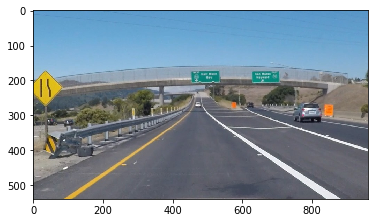

In [37]:
image_original = mpimg.imread('exit-ramp.jpg')
plt.imshow(image_original)
plt.show()


The output of Lane Detection algorithm is shown below:

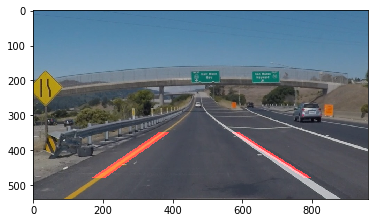

In [36]:
	combo = laneDet.write_imageoutput()
	plt.imshow(combo)
	plt.show()